<a href="https://colab.research.google.com/github/omkarmohite123/Project-Evaluating-language-knowledge-of-ELL-students-from-grades-8-12-using-NLP.ipynb/blob/main/Project_Evaluating_language_knowledge_of_ELL_students_from_grades_8_12_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload Dataset

In [9]:
from google.colab import files
uploaded=files.upload()

Saving sample_submission.csv to sample_submission.csv


#Import

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

from lightgbm import LGBMRegressor
from sklearn import model_selection
from sklearn import metrics

import string
from nltk.corpus import stopwords

import nltk
from nltk.stem.snowball import SnowballStemmer

# d2v import
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [11]:
train =pd.read_csv("/content/train.csv") 
test =pd.read_csv("/content/test.csv")
sample=pd.read_csv("/content/sample_submission.csv")

In [12]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [13]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


#EDA: check score features distributions


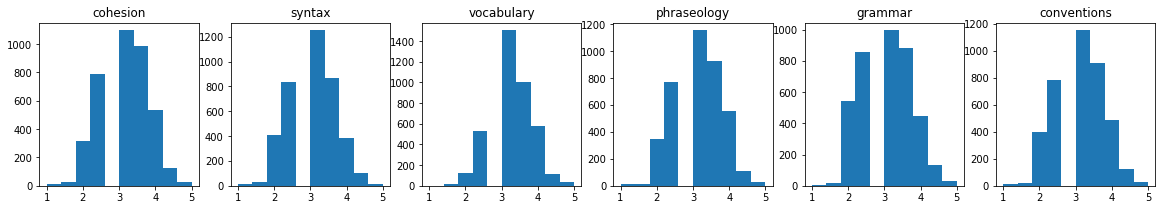

In [14]:
score_features=list(train.columns)
score_features.remove('text_id')
score_features.remove('full_text')

plt.rcParams["figure.figsize"] = (20,3)

fig,ax=plt.subplots(1,6)
count=0
for f in score_features:
    ax[count].hist(list(train[f].values))
    ax[count].set_title(f)
    count=count+1
    
plt.show()

#First question: why is there no value between 2.5 and 3 for any of the variables?



#EDA: check essay length


In [15]:
# check length of content
def get_length_of_text(x):
    return len(x)

print(f'Average length: {train.full_text.apply(lambda x: get_length_of_text(x)).mean():0.2f}')
print(f'Std length: {train.full_text.apply(lambda x: get_length_of_text(x)).std():0.2f}')
print(f'Min length: {train.full_text.apply(lambda x: get_length_of_text(x)).min():0.2f}')
print(f'Max length: {train.full_text.apply(lambda x: get_length_of_text(x)).max():0.2f}')


Average length: 2334.52
Std length: 1033.41
Min length: 82.00
Max length: 6044.00


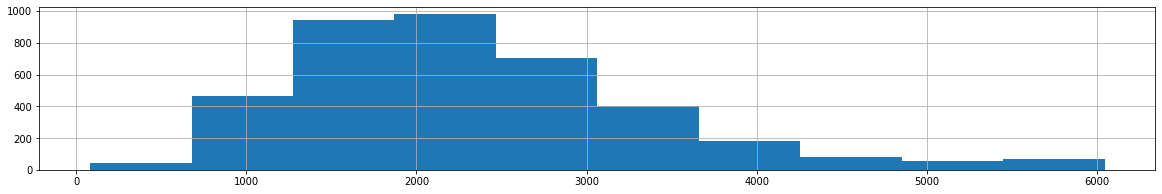

In [16]:
train.full_text.apply(lambda x: get_length_of_text(x)).hist();

#EDA: Check nans


In [17]:
train.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

#EDA: Check correlations


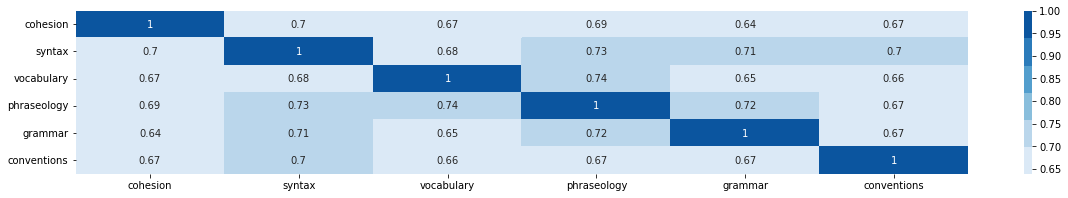

In [18]:
colormap = sns.color_palette("Blues")
sns.heatmap(train.corr(), annot=True, cmap=colormap);

#All variables are *correlated* with each other


#Vectorization and Modeling


We will build 6 models each predict a score

to represent a essay, I will use Doc2Vec (D2V) model to encode the essay to an array

#1. tokenize and stemming

In [19]:
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = []
    pattern = r'''(?x)          
        (?:[A-Z]\.)+        
      | \w+(?:-\w+)*       
      | \$?\d+(?:\.\d+)?%?  
      | \.\.\.              
      | [][.,;"'?():_`-]   
    '''
    # Stokenize the document, generate a list of string 
    for word in nltk.regexp_tokenize(text, pattern):
        tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha(): # filter out non alphabet words like emoji
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [20]:
processed_essays_train=[]
processed_essays_test=[]

for ess in list(train['full_text']):
    processed_essays_train.append(tokenization_and_stemming(ess))
for ess in list(test['full_text']):
    processed_essays_test.append(tokenization_and_stemming(ess))
    
processed_essays=[]
processed_essays.extend(processed_essays_train)
processed_essays.extend(processed_essays_test)

#2. tag essays and DOC2VEC processing


In [21]:
# tag document
processed_essays_train_tagged = [TaggedDocument(processed_essays_train[i], list(train.iloc[i,2:8])) for i in range(0,len(processed_essays_train))]

In [22]:
processed_essays_train_tagged[0]

TaggedDocument(words=['i', 'think', 'that', 'student', 'would', 'benefit', 'from', 'learn', 'at', 'home', 'becaus', 'they', 'wont', 'have', 'to', 'chang', 'and', 'get', 'up', 'earli', 'in', 'the', 'morn', 'to', 'shower', 'and', 'do', 'there', 'hair', 'take', 'onli', 'class', 'help', 'them', 'becaus', 'at', 'there', 'hous', 'they', 'll', 'be', 'pay', 'more', 'attent', 'they', 'will', 'be', 'comfort', 'at', 'home', 'the', 'hardest', 'part', 'of', 'school', 'is', 'get', 'readi', 'you', 'wake', 'up', 'go', 'brush', 'your', 'teeth', 'and', 'go', 'to', 'your', 'closet', 'and', 'look', 'at', 'your', 'cloth', 'after', 'you', 'think', 'you', 'pick', 'a', 'outfit', 'u', 'go', 'look', 'in', 'the', 'mirror', 'and', 'youll', 'either', 'not', 'like', 'it', 'or', 'you', 'look', 'and', 'see', 'a', 'stain', 'then', 'you', 'll', 'have', 'to', 'chang', 'with', 'the', 'onlin', 'class', 'you', 'can', 'wear', 'anyth', 'and', 'stay', 'home', 'and', 'you', 'wont', 'need', 'to', 'stress', 'about', 'what', 'to'

In [23]:
# doc2vec model
doc2vecModel = Doc2Vec(vector_size=2000, window=2, dm=0,min_count=1, workers=8, epochs = 40)
#build vocab
doc2vecModel.build_vocab(processed_essays_train_tagged)
#train model
doc2vecModel.train(processed_essays_train_tagged, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

In [24]:
# doc vec gen
xx=[doc2vecModel.infer_vector(processed_essays_train[i]) for i in range(0,len(processed_essays_train))]

#now xx should be the vectors of essays, use tsne to check its separatbility


In [25]:
# score types and colors
#score_color = []
#score_list=[1,1.5,2,2.5,3,3.5,4,4.5,5]

#for s in train.iloc[:,2:8].values:


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


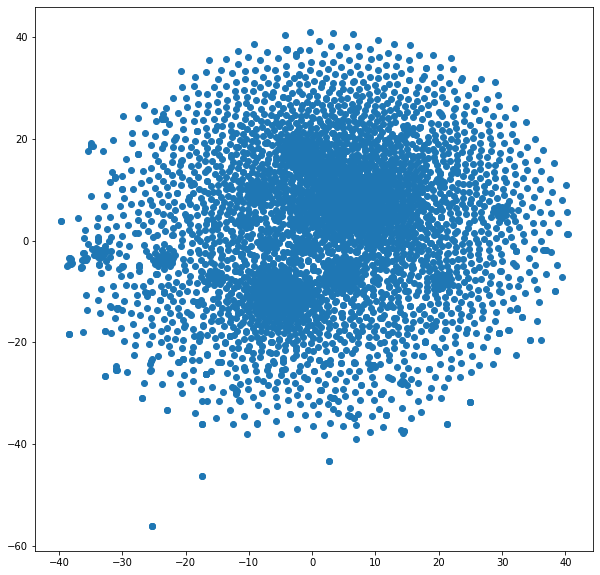

In [26]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(xx)

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.show()

3. feature data generation with d2v results


In [27]:
X = np.array(xx)

In [28]:
cohesion_train = train.cohesion.values
syntax_train = train.syntax.values
vocabulary_train = train.vocabulary.values
phraseology_train = train.phraseology.values
grammar_train = train.grammar.values
conventions_train = train.conventions.values

#Hyperparameter optimization with Optuna


In [29]:
optuna_train_values=np.zeros(len(cohesion_train))


In [31]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.6 MB/s 
     |████████████████████████████████| 209 kB 66.3 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 66.2 MB/s 
     |████████████████████████████████| 147 kB 61.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=03030b990a01a8e553457d1fafd29f2668ce2d45d5b864ed7e02bd2017a93033
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [35]:
!pip install lightgbm.callback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement lightgbm.callback (from versions: none)
ERROR: No matching distribution found for lightgbm.callback


In [36]:
import optuna
#from lightgbm.callback import log_evaluation, early_stopping


def objective(trial, data=X, target=optuna_train_values):
    print(optuna_train_values)
    train_x, test_x, train_y, test_y = model_selection.train_test_split(data, target, test_size=0.3, random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.001, 0.01, 0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.2, 0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.004, 0.008, 0.01, 0.02, 0.05, .1, 0.2, 0.5]),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20,100, 150]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], callbacks=[log_evaluation(period=0)])
    
    preds = model.predict(test_x)
    
    rmse = np.sqrt(metrics.mean_squared_error(test_y, preds))
    
    return rmse

In [ ]:
#all_train_vals=[cohesion_train,syntax_train,vocabulary_train,phraseology_train,grammar_train,conventions_train]
#studies=[]
#for i in range(0,len(all_train_vals)):
#    optuna_train_values=all_train_vals[i]
    
#    optuna.logging.set_verbosity(optuna.logging.INFO)

#    study = optuna.create_study(direction='minimize')
#    study.optimize(objective, n_trials=50)
#    print(f'Number of finished trials: {len(study.trials)}')
#    print(f'Best trial: {study.best_trial.params}')
#    print(f'Best score: {study.best_value}')
#    studies.append(study)

In [ ]:
#cohesion_best_params = studies[0].best_trial.params
#syntax_best_params = studies[1].best_trial.params
#vocabulary_best_params = studies[2].best_trial.params
#phraseology_best_params = studies[3].best_trial.params
#grammar_best_params =studies[4].best_trial.params
#conventions_best_params =studies[5].best_trial.params

In [ ]:
#for i in range(0,6):
#    print(studies[i].best_trial.params)

In [37]:
cohesion_best_params = {'n_estimators': 61, 'reg_alpha': 0.19628342273354243, 'reg_lambda': 9.065652312939543, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 241}
syntax_best_params = {'n_estimators': 99, 'reg_alpha': 0.046444714143389895, 'reg_lambda': 0.06051595166886711, 'colsample_bytree': 0.6, 'subsample': 0.2, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_samples': 121}
vocabulary_best_params = {'n_estimators': 497, 'reg_alpha': 0.29474348628071534, 'reg_lambda': 1.9286577626868704, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 25}
phraseology_best_params ={'n_estimators': 16, 'reg_alpha': 0.2912483722327398, 'reg_lambda': 0.7934234053915282, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 207}
grammar_best_params = {'n_estimators': 264, 'reg_alpha': 6.681049401764443, 'reg_lambda': 0.0031323977834200206, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 162}
conventions_best_params = {'n_estimators': 278, 'reg_alpha': 2.268247355659357, 'reg_lambda': 1.844391747146949, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 150, 'min_child_samples': 178}

#training

In [38]:
training_performances_container = []
val_performances_container = []

In [39]:
cv_strategy = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

performances = {}

for var in [("cohesion", cohesion_train, cohesion_best_params), ("syntax", syntax_train, syntax_best_params), ("vocabulary", vocabulary_train, vocabulary_best_params), 
            ("phraseology", phraseology_train, phraseology_best_params), ("grammar", grammar_train, grammar_best_params), ("conventions", conventions_train, conventions_best_params)]:
    print(f'Validating on {var[0]}')
    fold = 0
    train_scores = []
    val_scores = []
    
    for train_idx, val_idx in cv_strategy.split(X, var[1]):

        # train
        X_train = X[train_idx]
        y_train = var[1][train_idx]

        # validation
        X_val = X[val_idx]
        y_val = var[1][val_idx]

        # training
        model = LGBMRegressor(**var[2])
        model.fit(X_train, y_train)

        # predicting
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # storing scores
        train_score = np.sqrt(metrics.mean_squared_error(y_train, train_preds))
        val_score = np.sqrt(metrics.mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)

        print(f"Fold {fold} ==> Train accuracy: {train_score:0.4f} | Validation accuracy: {val_score:0.4f}")
        fold += 1

    training_performance = np.mean(train_scores)
    val_performance = np.mean(val_scores)
    
    training_performances_container.append(training_performance)
    val_performances_container.append(val_performance)
    print(f"END. Average training performance: {training_performance:0.4f} | Average validation performance: {val_performance:0.4f}")

Validating on cohesion
Fold 0 ==> Train accuracy: 0.6101 | Validation accuracy: 0.6088
Fold 1 ==> Train accuracy: 0.6076 | Validation accuracy: 0.6317
Fold 2 ==> Train accuracy: 0.6099 | Validation accuracy: 0.6161
Fold 3 ==> Train accuracy: 0.6038 | Validation accuracy: 0.6401
Fold 4 ==> Train accuracy: 0.6092 | Validation accuracy: 0.6203
END. Average training performance: 0.6081 | Average validation performance: 0.6234
Validating on syntax
Fold 0 ==> Train accuracy: 0.5284 | Validation accuracy: 0.5809
Fold 1 ==> Train accuracy: 0.5294 | Validation accuracy: 0.5804
Fold 2 ==> Train accuracy: 0.5288 | Validation accuracy: 0.5794
Fold 3 ==> Train accuracy: 0.5276 | Validation accuracy: 0.5835
Fold 4 ==> Train accuracy: 0.5323 | Validation accuracy: 0.5657
END. Average training performance: 0.5293 | Average validation performance: 0.5780
Validating on vocabulary
Fold 0 ==> Train accuracy: 0.2124 | Validation accuracy: 0.4525
Fold 1 ==> Train accuracy: 0.2117 | Validation accuracy: 0.46

In [40]:
cohesion_model = LGBMRegressor(**cohesion_best_params)
syntax_model = LGBMRegressor(**syntax_best_params)
vocabulary_model = LGBMRegressor(**vocabulary_best_params)
phraseology_model = LGBMRegressor(**phraseology_best_params)
grammar_model = LGBMRegressor(**grammar_best_params)
conventions_model = LGBMRegressor(**conventions_best_params)

In [41]:
print(f'Fitting Cohesion Model')
cohesion_model.fit(X, cohesion_train)
print(f'Fitting Syntax Model')
syntax_model.fit(X, syntax_train)
print(f'Fitting Vocabulary Model')
vocabulary_model.fit(X, vocabulary_train)
print(f'Fitting Phraseology Model')
phraseology_model.fit(X, phraseology_train)
print(f'Fitting Grammar Model')
grammar_model.fit(X, grammar_train)
print(f'Fitting Conventions Model')
conventions_model.fit(X, conventions_train)

Fitting Cohesion Model
Fitting Syntax Model
Fitting Vocabulary Model
Fitting Phraseology Model
Fitting Grammar Model
Fitting Conventions Model


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.2, max_depth=150,
              min_child_samples=178, n_estimators=278,
              reg_alpha=2.268247355659357, reg_lambda=1.844391747146949,
              subsample=0.6)

#generate output

In [42]:
xx=[doc2vecModel.infer_vector(processed_essays_test[i]) for i in range(0,len(processed_essays_test))]

In [43]:
X_test = np.array(xx)

In [44]:
cohesion_predictions = cohesion_model.predict(X_test)
syntax_predictions = syntax_model.predict(X_test)
vocabulary_predictions = vocabulary_model.predict(X_test)
phraseology_predictions = phraseology_model.predict(X_test)
grammar_predictions = grammar_model.predict(X_test)
conventions_predictions = conventions_model.predict(X_test)

In [45]:
submission = test.copy()
submission=submission.drop('full_text',axis=1)
submission['cohesion'] = cohesion_predictions
submission['syntax'] = syntax_predictions
submission['vocabulary'] = vocabulary_predictions
submission['phraseology'] = phraseology_predictions
submission['grammar'] = grammar_predictions
submission['conventions'] = conventions_predictions

In [46]:
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.094363,2.838046,3.048167,2.971879,2.829055,2.925461
1,000BAD50D026,3.045275,2.892546,3.207672,3.034207,3.128108,3.470155
2,00367BB2546B,3.142585,3.186454,3.606307,3.292800,3.712585,3.605537


In [47]:
submission.to_csv("submission.csv", index=False)

#succesfully created submission anylisis